# Notebook

In [1]:
from src.kernels import gaussian_kernel,laplacian_kernel
from src.model import KernelRegressor
from src.get_data import get_mnist,get_fashion_mnist,inject_label_noise
from sklearn.model_selection import train_test_split
from src.metrics import accuracy
import torch
import matplotlib.pyplot as plt

## Various tests

In [2]:
data,target=get_mnist(n_samples=500,flatten=True)
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=42)

In [3]:
def print_info():
    print(f'Data shape: {data.shape}')
    print(f'Target shape: {target.shape}\n')
    print("Training samples:",X_train.shape[0])
    print("Test samples:",X_test.shape[0])
    print("\nFeature shape:",X_train.shape)
    print("Labels shape:",y_train.shape)
print_info()

Data shape: torch.Size([500, 784])
Target shape: torch.Size([500])

Training samples: 400
Test samples: 100

Feature shape: torch.Size([400, 784])
Labels shape: torch.Size([400])


In [4]:
kernel_reg=KernelRegressor(kernel_func=gaussian_kernel,sigma=5.0,model_type='interpolator')
kernel_reg.set_train_data(X_train,y_train)
kernel_reg.invers_fit()

print("Kernel matrix shape:",kernel_reg.K.shape)
print("Alpha coefficient shape:", kernel_reg.alpha.shape)

rkhs_norm=kernel_reg.compute_rkhs_norm()
print(f"RKHS norm of the learned function f*: {rkhs_norm.item():.3f}")


Training data set with 400 samples and 784 features on cuda.
Kernel matrix shape: torch.Size([400, 400])
Alpha coefficient shape: torch.Size([400, 10])
RKHS norm of the learned function f*: 15.222


In [5]:
# train accuracy 
predictions=kernel_reg.predict(X_train)
accuracy_train=accuracy(predictions,y_train.to('cuda'))
print("Train accuracy:",accuracy_train)

# test accuracy 
predictions=kernel_reg.predict(X_test)
accuracy_test=accuracy(predictions,y_test.to('cuda'))

print("\nTest accuracy:",accuracy_test)

Train accuracy: 1.0

Test accuracy: 0.85999995470047


In [6]:
noise_levels=[0.01,0.1]

for noise in noise_levels:
    noisy_y_train=inject_label_noise(y_train,noise_ratio=noise).to('cuda')
    kernel_reg.set_train_data(X_train,noisy_y_train.to('cuda'))
    kernel_reg.invers_fit()
    predictions=kernel_reg.predict(X_test)
    acc=accuracy(predictions,y_test.to('cuda'))
    print(f"Noise level: {noise}, Test accuracy: {acc:.3f}")
    print(f"RKHS norm: {kernel_reg.compute_rkhs_norm().item():.3f}\n")
    

Training data set with 400 samples and 784 features on cuda.
Noise level: 0.01, Test accuracy: 0.850
RKHS norm: 15.619

Training data set with 400 samples and 784 features on cuda.
Noise level: 0.1, Test accuracy: 0.820
RKHS norm: 18.675



## Generalization

Comparison for Laplacian and Gaussian kernels on their ability to generalize even after interpolating.


In [7]:
from src.training import Trainer

data,target=get_mnist(n_samples=50,flatten=True)
#data,target=get_fashion_mnist(n_samples=5000,flatten=True)

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=42)
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / (std + 1e-6)
X_test = (X_test - mean) / (std + 1e-6)


In [8]:
# 2. Setup Experiment
kernels = {
    'Gaussian': {'func': gaussian_kernel, 'color': 'blue'},
    'Laplacian': {'func': laplacian_kernel, 'color': 'red'}
}
sigma=40.0

epochs = [1, 5, 10, 15, 20]
results = {}


In [9]:
# --- Inverse Fit (Interpolator) ---


for k_name, k_params in kernels.items():
    if k_name not in results:
        results[k_name] = {}

    print(f"Running {k_name} Inverse Fit...")

    model_inv = KernelRegressor(kernel_func=k_params['func'], sigma=sigma, model_type='interpolator')
    model_inv.set_train_data(X_train, y_train)
    model_inv.fit() 

    y_pred_inv = model_inv.predict(X_test)  
    y_train_pred_inv = model_inv.predict(X_train) 


    device = y_pred_inv.device

    y_train_gpu = y_train.to(device)
    y_test_gpu = y_test.to(device)

    inv_metrics = {
        'train_mse': model_inv.compute_mse_loss(y_train_gpu, y_train_pred_inv),
        'test_mse': model_inv.compute_mse_loss(y_test_gpu, y_pred_inv),
        'classification_error': model_inv.compute_classification_error(y_test_gpu, y_pred_inv)
    }

    results[k_name]['Inverse'] = inv_metrics

    print(f"-> {k_name} Inverse Done. Test MSE: {inv_metrics['test_mse']:.4f}")

Running Gaussian Inverse Fit...
Training data set with 40 samples and 784 features on cuda.
-> Gaussian Inverse Done. Test MSE: 0.0479
Running Laplacian Inverse Fit...
Training data set with 40 samples and 784 features on cuda.
-> Laplacian Inverse Done. Test MSE: 0.0538


In [21]:
 # --- EigenPro Fit (Optimizer) ---
for k_name, k_params in kernels.items():

    print(f"Running {k_name} EigenPro Fit...")
    model_opt = KernelRegressor(kernel_func=k_params['func'], sigma=sigma, model_type='optimizer')

    trainer_opt = Trainer(model_opt)
    trainer_opt.set_data(X_train, y_train, X_test, y_test)

    # Train with specific checkpoints
    opt_metrics = trainer_opt.train_epochs(checkpoints=epochs)
    results[k_name]['EigenPro'] = opt_metrics


Running Gaussian EigenPro Fit...
Training data set with 40 samples and 784 features on cpu.
Initialisation du modèle EigenPro...
SVD time: 0.02s, top_q: 5, top_eigval: 0.71, new top_eigval: 2.28e-02
n_subsamples=40, bs_gpu=40, eta=74.33, bs=256, top_eigval=7.11e-01, beta=1.00
--------------------
epoch:   0    time: 00.0s    train accuracy: 95.00%     train mse: 7.32e-02     
EigenPro optimization completed.
completed fit at epoch 1
Stats -> Test Acc: 0.30 | Test MSE: 0.0896
completed logging at epoch 1
SVD time: 0.01s, top_q: 5, top_eigval: 0.71, new top_eigval: 2.28e-02
n_subsamples=40, bs_gpu=40, eta=74.33, bs=256, top_eigval=7.11e-01, beta=1.00
--------------------
epoch:   0    time: 00.0s    train accuracy: 97.50%     train mse: 5.57e-02     
epoch:   1    time: 00.0s    train accuracy: 97.50%     train mse: 4.40e-02     
epoch:   2    time: 00.0s    train accuracy: 97.50%     train mse: 3.59e-02     
epoch:   3    time: 00.0s    train accuracy: 97.50%     train mse: 3.00e-02    

Plotting results...


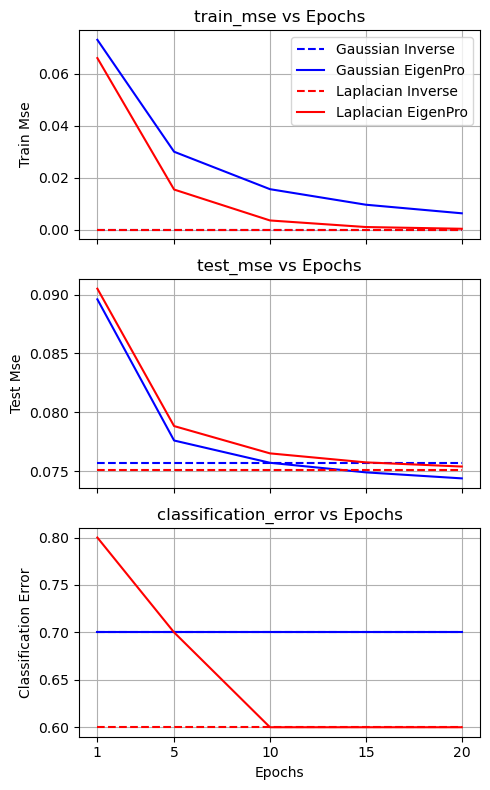

In [22]:
# 4. Plotting
print("Plotting results...")
metrics_to_plot = ['train_mse', 'test_mse', 'classification_error']
fig, axes = plt.subplots(3, 1, figsize=(5, 8),sharex=True)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    for k_name, k_params in kernels.items():
        color = k_params['color']

        # Plot Inverse (Dotted)
        inv_val = results[k_name]['Inverse'][metric]
        ax.plot(epochs, [inv_val] * len(epochs),
                color=color, linestyle='--', label=f'{k_name} Inverse')

        # Plot EigenPro (Solid)
        opt_vals = results[k_name]['EigenPro'][metric]
        ax.plot(epochs, opt_vals,
                color=color, linestyle='-', label=f'{k_name} EigenPro')


    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric} vs Epochs')
    ax.grid(True)


    if i == 0:
        ax.legend(loc='upper right')
ax.set_xticks(epochs)
ax.set_xlabel('Epochs')

plt.tight_layout()
plt.show()

<details>
  <summary><b>Cliquez pour voir les logs d'entraînement (EigenPro) pour MNIST</b></summary>
  <pre>
Running Gaussian EigenPro Fit...
Training data set with 24000 samples and 784 features on cuda.
Initialisation du modèle EigenPro...
SVD time: 0.29s, top_q: 93, top_eigval: 0.71, new top_eigval: 5.10e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.14e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 95.84%     train mse: 1.54e-02     
EigenPro optimization completed.
completed fit at epoch 1
Stats -> Test Acc: 0.95 | Test MSE: 0.0165
completed logging at epoch 1
SVD time: 0.24s, top_q: 93, top_eigval: 0.71, new top_eigval: 5.06e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.13e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 96.80%     train mse: 1.31e-02     
epoch:   1    time: 00.7s    train accuracy: 97.40%     train mse: 1.17e-02     
epoch:   2    time: 00.7s    train accuracy: 97.72%     train mse: 1.08e-02     
epoch:   3    time: 00.7s    train accuracy: 98.04%     train mse: 1.00e-02     
EigenPro optimization completed.
completed fit at epoch 5
Stats -> Test Acc: 0.97 | Test MSE: 0.0124
completed logging at epoch 5
SVD time: 0.24s, top_q: 95, top_eigval: 0.71, new top_eigval: 5.04e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.12e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 98.38%     train mse: 9.26e-03     
epoch:   1    time: 00.7s    train accuracy: 98.60%     train mse: 8.78e-03     
epoch:   2    time: 00.7s    train accuracy: 98.68%     train mse: 8.37e-03     
epoch:   3    time: 00.7s    train accuracy: 98.84%     train mse: 8.04e-03     
epoch:   4    time: 00.7s    train accuracy: 98.88%     train mse: 7.73e-03     
EigenPro optimization completed.
completed fit at epoch 10
Stats -> Test Acc: 0.97 | Test MSE: 0.0112
completed logging at epoch 10
SVD time: 0.24s, top_q: 95, top_eigval: 0.71, new top_eigval: 5.04e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.11e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 99.00%     train mse: 7.32e-03     
epoch:   1    time: 00.7s    train accuracy: 99.06%     train mse: 7.10e-03     
epoch:   2    time: 00.7s    train accuracy: 99.10%     train mse: 6.86e-03     
epoch:   3    time: 00.7s    train accuracy: 99.30%     train mse: 6.62e-03     
epoch:   4    time: 00.7s    train accuracy: 99.24%     train mse: 6.44e-03     
EigenPro optimization completed.
completed fit at epoch 15
Stats -> Test Acc: 0.98 | Test MSE: 0.0106
completed logging at epoch 15
SVD time: 0.24s, top_q: 94, top_eigval: 0.71, new top_eigval: 5.06e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.11e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 99.44%     train mse: 5.96e-03     
epoch:   1    time: 00.7s    train accuracy: 99.42%     train mse: 5.79e-03     
epoch:   2    time: 00.7s    train accuracy: 99.48%     train mse: 5.64e-03     
epoch:   3    time: 00.7s    train accuracy: 99.46%     train mse: 5.46e-03     
epoch:   4    time: 00.7s    train accuracy: 99.50%     train mse: 5.36e-03     
EigenPro optimization completed.
completed fit at epoch 20
Stats -> Test Acc: 0.97 | Test MSE: 0.0103
completed logging at epoch 20
SVD time: 0.25s, top_q: 94, top_eigval: 0.71, new top_eigval: 5.03e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.13e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 99.50%     train mse: 5.36e-03     
epoch:   1    time: 00.7s    train accuracy: 99.58%     train mse: 5.24e-03     
epoch:   2    time: 00.7s    train accuracy: 99.60%     train mse: 5.13e-03     
epoch:   3    time: 00.7s    train accuracy: 99.62%     train mse: 5.04e-03     
epoch:   4    time: 00.7s    train accuracy: 99.66%     train mse: 4.89e-03     
EigenPro optimization completed.
completed fit at epoch 25
Stats -> Test Acc: 0.98 | Test MSE: 0.0100
completed logging at epoch 25
Running Laplacian EigenPro Fit...
Training data set with 24000 samples and 784 features on cuda.
Initialisation du modèle EigenPro...
SVD time: 12.33s, top_q: 196, top_eigval: 0.44, new top_eigval: 4.80e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.41e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 99.88%     train mse: 5.15e-03     
EigenPro optimization completed.
completed fit at epoch 1
Stats -> Test Acc: 0.97 | Test MSE: 0.0103
completed logging at epoch 1
SVD time: 0.27s, top_q: 194, top_eigval: 0.44, new top_eigval: 4.82e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.44e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 99.94%     train mse: 2.19e-03     
epoch:   1    time: 00.6s    train accuracy: 100.00%     train mse: 1.04e-03     
epoch:   2    time: 00.6s    train accuracy: 100.00%     train mse: 5.24e-04     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 2.79e-04     
EigenPro optimization completed.
completed fit at epoch 5
Stats -> Test Acc: 0.98 | Test MSE: 0.0081
completed logging at epoch 5
SVD time: 0.27s, top_q: 195, top_eigval: 0.44, new top_eigval: 4.82e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.43e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 100.00%     train mse: 1.49e-04     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 8.34e-05     
epoch:   2    time: 00.6s    train accuracy: 100.00%     train mse: 4.78e-05     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 2.80e-05     
epoch:   4    time: 00.7s    train accuracy: 100.00%     train mse: 1.71e-05     
EigenPro optimization completed.
completed fit at epoch 10
Stats -> Test Acc: 0.98 | Test MSE: 0.0079
completed logging at epoch 10
SVD time: 35.30s, top_q: 202, top_eigval: 0.44, new top_eigval: 4.74e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.43e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 100.00%     train mse: 1.03e-05     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 6.33e-06     
epoch:   2    time: 00.7s    train accuracy: 100.00%     train mse: 4.03e-06     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 2.63e-06     
epoch:   4    time: 00.6s    train accuracy: 100.00%     train mse: 1.76e-06     
EigenPro optimization completed.
completed fit at epoch 15
Stats -> Test Acc: 0.98 | Test MSE: 0.0078
completed logging at epoch 15
SVD time: 90.75s, top_q: 196, top_eigval: 0.45, new top_eigval: 4.81e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.46e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 100.00%     train mse: 1.20e-06     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 8.52e-07     
epoch:   2    time: 00.6s    train accuracy: 100.00%     train mse: 5.86e-07     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 4.20e-07     
epoch:   4    time: 00.6s    train accuracy: 100.00%     train mse: 3.07e-07     
EigenPro optimization completed.
completed fit at epoch 20
Stats -> Test Acc: 0.98 | Test MSE: 0.0078
completed logging at epoch 20
SVD time: 61.12s, top_q: 199, top_eigval: 0.44, new top_eigval: 4.80e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.44e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 100.00%     train mse: 2.40e-07     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 1.81e-07     
epoch:   2    time: 00.6s    train accuracy: 100.00%     train mse: 1.38e-07     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 1.05e-07     
epoch:   4    time: 00.6s    train accuracy: 100.00%     train mse: 8.28e-08     
EigenPro optimization completed.
completed fit at epoch 25
Stats -> Test Acc: 0.98 | Test MSE: 0.0078
completed logging at epoch 25

  </pre>
</details>

<details>
  <summary><b>Cliquez pour voir les resultats d'entraînement (EigenPro)</b></summary>
  <pre>
  {'Gaussian': {'Inverse': {'train_mse': 6.9188983431445195e-09, 'test_mse': 0.007039347197860479, 'classification_error': 0.017333333333333333}, 'EigenPro': {'rkhs_norm': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'test_mse': [0.016501013189554214, 0.01240057498216629, 0.011192399077117443, 0.010626384988427162, 0.010279028676450253, 0.010018174536526203], 'train_mse': [0.014796843752264977, 0.009375416673719883, 0.0073012495413422585, 0.006190372630953789, 0.005418808665126562, 0.00480082631111145], 'accuracy': [0.9521666765213013, 0.9695000052452087, 0.9736666679382324, 0.9751666784286499, 0.9745000004768372, 0.9764999747276306], 'classification_error': [0.04783333333333333, 0.0305, 0.026333333333333334, 0.024833333333333332, 0.0255, 0.0235], 'var': [1, 5, 10, 15, 20, 25]}}, 'Laplacian': {'Inverse': {'train_mse': 2.2527896215152055e-11, 'test_mse': 0.008098999038338661, 'classification_error': 0.022}, 'EigenPro': {'rkhs_norm': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'test_mse': [0.010308272205293179, 0.008064289577305317, 0.007861719466745853, 0.007833912968635559, 0.007828718982636929, 0.007827325724065304], 'train_mse': [0.00511664804071188, 0.000287207163637504, 1.8599219401949085e-05, 2.1754663066531066e-06, 4.1805407136052963e-07, 1.075738680356153e-07], 'accuracy': [0.972000002861023, 0.9774999618530273, 0.9783332943916321, 0.9783332943916321, 0.9785000085830688, 0.9785000085830688], 'classification_error': [0.028, 0.0225, 0.021666666666666667, 0.021666666666666667, 0.0215, 0.0215], 'var': [1, 5, 10, 15, 20, 25]}}}

  <pre>
<details>

<details>
  <summary><b>Cliquez pour voir les logs d'entraînement (EigenPro) pour Fashion Mnist</b></summary>
  <pre>
  Running Gaussian EigenPro Fit...
Training data set with 24000 samples and 784 features on cuda.
Initialisation du modèle EigenPro...
SVD time: 0.65s, top_q: 69, top_eigval: 0.72, new top_eigval: 5.11e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.21e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 87.16%     train mse: 2.44e-02     
EigenPro optimization completed.
completed fit at epoch 1
Stats -> Test Acc: 0.85 | Test MSE: 0.0266
completed logging at epoch 1
SVD time: 0.23s, top_q: 69, top_eigval: 0.72, new top_eigval: 5.03e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.19e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 88.88%     train mse: 2.16e-02     
epoch:   1    time: 00.7s    train accuracy: 89.54%     train mse: 2.03e-02     
epoch:   2    time: 00.7s    train accuracy: 90.48%     train mse: 1.94e-02     
epoch:   3    time: 00.6s    train accuracy: 91.22%     train mse: 1.85e-02     
EigenPro optimization completed.
completed fit at epoch 5
Stats -> Test Acc: 0.87 | Test MSE: 0.0233
completed logging at epoch 5
SVD time: 0.23s, top_q: 70, top_eigval: 0.72, new top_eigval: 5.00e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.22e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 90.70%     train mse: 1.86e-02     
epoch:   1    time: 00.7s    train accuracy: 91.16%     train mse: 1.81e-02     
epoch:   2    time: 00.7s    train accuracy: 91.26%     train mse: 1.76e-02     
epoch:   3    time: 00.7s    train accuracy: 91.34%     train mse: 1.71e-02     
epoch:   4    time: 00.7s    train accuracy: 92.06%     train mse: 1.68e-02     
EigenPro optimization completed.
completed fit at epoch 10
Stats -> Test Acc: 0.88 | Test MSE: 0.0222
completed logging at epoch 10
SVD time: 0.23s, top_q: 72, top_eigval: 0.72, new top_eigval: 5.10e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.18e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 92.70%     train mse: 1.64e-02     
epoch:   1    time: 00.7s    train accuracy: 92.84%     train mse: 1.60e-02     
epoch:   2    time: 00.7s    train accuracy: 93.12%     train mse: 1.57e-02     
epoch:   3    time: 00.7s    train accuracy: 93.18%     train mse: 1.55e-02     
epoch:   4    time: 00.7s    train accuracy: 93.38%     train mse: 1.53e-02     
EigenPro optimization completed.
completed fit at epoch 15
Stats -> Test Acc: 0.88 | Test MSE: 0.0217
completed logging at epoch 15
SVD time: 0.23s, top_q: 71, top_eigval: 0.72, new top_eigval: 5.06e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=7.19e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 93.36%     train mse: 1.52e-02     
epoch:   1    time: 00.7s    train accuracy: 93.72%     train mse: 1.49e-02     
epoch:   2    time: 00.7s    train accuracy: 93.52%     train mse: 1.48e-02     
epoch:   3    time: 00.7s    train accuracy: 93.80%     train mse: 1.45e-02     
epoch:   4    time: 00.7s    train accuracy: 93.96%     train mse: 1.43e-02     
EigenPro optimization completed.
completed fit at epoch 20
Stats -> Test Acc: 0.89 | Test MSE: 0.0213
completed logging at epoch 20
Running Laplacian EigenPro Fit...
Training data set with 24000 samples and 784 features on cuda.
Initialisation du modèle EigenPro...
SVD time: 15.50s, top_q: 161, top_eigval: 0.46, new top_eigval: 4.81e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.59e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 96.74%     train mse: 1.13e-02     
EigenPro optimization completed.
completed fit at epoch 1
Stats -> Test Acc: 0.88 | Test MSE: 0.0206
completed logging at epoch 1
SVD time: 29.31s, top_q: 166, top_eigval: 0.46, new top_eigval: 4.70e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.58e-01, beta=1.00
--------------------
epoch:   0    time: 00.6s    train accuracy: 99.30%     train mse: 6.47e-03     
epoch:   1    time: 00.7s    train accuracy: 99.86%     train mse: 3.84e-03     
epoch:   2    time: 00.7s    train accuracy: 100.00%     train mse: 2.45e-03     
epoch:   3    time: 00.6s    train accuracy: 100.00%     train mse: 1.56e-03     
EigenPro optimization completed.
completed fit at epoch 5
Stats -> Test Acc: 0.89 | Test MSE: 0.0182
completed logging at epoch 5
SVD time: 78.09s, top_q: 164, top_eigval: 0.46, new top_eigval: 4.73e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.59e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 100.00%     train mse: 1.03e-03     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 6.75e-04     
epoch:   2    time: 00.7s    train accuracy: 100.00%     train mse: 4.51e-04     
epoch:   3    time: 00.7s    train accuracy: 100.00%     train mse: 3.08e-04     
epoch:   4    time: 00.7s    train accuracy: 100.00%     train mse: 2.12e-04     
EigenPro optimization completed.
completed fit at epoch 10
Stats -> Test Acc: 0.90 | Test MSE: 0.0179
completed logging at epoch 10
SVD time: 0.26s, top_q: 163, top_eigval: 0.46, new top_eigval: 4.84e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.57e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 100.00%     train mse: 1.52e-04     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 1.09e-04     
epoch:   2    time: 00.7s    train accuracy: 100.00%     train mse: 7.59e-05     
epoch:   3    time: 00.7s    train accuracy: 100.00%     train mse: 5.39e-05     
epoch:   4    time: 00.7s    train accuracy: 100.00%     train mse: 3.83e-05     
EigenPro optimization completed.
completed fit at epoch 15
Stats -> Test Acc: 0.90 | Test MSE: 0.0178
completed logging at epoch 15
SVD time: 0.26s, top_q: 160, top_eigval: 0.46, new top_eigval: 4.82e-04
n_subsamples=2000, bs_gpu=2000, eta=256.00, bs=256, top_eigval=4.57e-01, beta=1.00
--------------------
epoch:   0    time: 00.7s    train accuracy: 100.00%     train mse: 2.35e-05     
epoch:   1    time: 00.7s    train accuracy: 100.00%     train mse: 1.67e-05     
epoch:   2    time: 00.7s    train accuracy: 100.00%     train mse: 1.23e-05     
epoch:   3    time: 00.7s    train accuracy: 100.00%     train mse: 8.85e-06     
epoch:   4    time: 00.7s    train accuracy: 100.00%     train mse: 6.44e-06     
EigenPro optimization completed.
completed fit at epoch 20
Stats -> Test Acc: 0.90 | Test MSE: 0.0178
completed logging at epoch 20

  <pre>
<details>

## Noise resistance (use colab or a beefy GPU)

Study of noise resistance and explosion of norm on MNIST

In [23]:
from src.training import Trainer

data_full, target_full = get_mnist(n_samples=500, flatten=True)

mean, std = data_full.mean(), data_full.std()
data_full = (data_full - mean) / (std + 1e-6)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    data_full, target_full, test_size=100, random_state=42,
)

In [24]:
train_sizes_list=[2000, 5000, 10000, 20000, 40000]

noise_levels=[0.0, 0.01,0.1]
sigma = 2.0

plot_data = {} 

In [25]:

for noise in noise_levels:
    print(f"=== Expérience : Bruit {noise*100}% ===")

    if noise > 0:
        y_train_noisy = inject_label_noise(y_train_full, noise)
    else:
        y_train_noisy = y_train_full

    print("\n--> Lancement Interpolation (Inverse)...")
    model_inv = KernelRegressor(gaussian_kernel, sigma=sigma, model_type='interpolator')
    trainer_inv = Trainer(model_inv)
    
    
    trainer_inv.set_data(X_train_full, y_train_noisy, X_test, y_test)

    res_inv = trainer_inv.train_size(train_sizes=train_sizes_list)

    plot_data[noise] = {
        'sizes': res_inv['var'],
        'inv_err': [e * 100 for e in res_inv['classification_error']],
        'inv_norm': res_inv['rkhs_norm'],

    }

=== Expérience : Bruit 0.0% ===

--> Lancement Interpolation (Inverse)...
Training data set with 400 samples and 784 features on cpu.
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
=== Expérience : Bruit 1.0% ===

--> Lancement Interpolation (Inverse)...
Training data set with 400 samples and 784 features on cpu.
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training da

<details>
    <summary>Cliquez pour voir les résultats d'entraînement (Inversion) pour  MNIST et différent niveau de bruit</b></summary>
    <pre>
    === Expérience : Bruit 0.0% ===

    --> Lancement Interpolation (Inverse)...
    Training data set with 49900 samples and 784 features on cpu.
    Training data set with 2000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.87 | Test MSE: 0.0998
    Training data set with 5000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.93 | Test MSE: 0.0997
    Training data set with 10000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.96 | Test MSE: 0.0994
    Training data set with 20000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.97 | Test MSE: 0.0988
    Training data set with 40000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.98 | Test MSE: 0.0981

    === Expérience : Bruit 1.0% ===

    --> Lancement Interpolation (Inverse)...
    Training data set with 49900 samples and 784 features on cpu.
    Training data set with 2000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.86 | Test MSE: 0.0998
    Training data set with 5000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.93 | Test MSE: 0.0997
    Training data set with 10000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.96 | Test MSE: 0.0994
    Training data set with 20000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.97 | Test MSE: 0.0988
    Training data set with 40000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.98 | Test MSE: 0.0981

    === Expérience : Bruit 10.0% ===

    --> Lancement Interpolation (Inverse)...
    Training data set with 49900 samples and 784 features on cpu.
    Training data set with 2000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.77 | Test MSE: 0.0998
    Training data set with 5000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.83 | Test MSE: 0.0998
    Training data set with 10000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.83 | Test MSE: 0.0995
    Training data set with 20000 samples and 784 features on cpu.
    Stats -> Test Acc: 0.89 | Test MSE: 0.0990
    Training data set with 40000 samples and 784 features on cpu.
<pre>
<details>

In [26]:

for noise in noise_levels:
    print(f"=== Expérience : Bruit {noise*100}% ===")

    if noise > 0:
        y_train_noisy = inject_label_noise(y_train_full, noise)
    else:
        y_train_noisy = y_train_full


    print("\n--> Lancement Interpolation (Inverse)...")
    model_inv = KernelRegressor(gaussian_kernel, sigma=sigma, model_type='interpolator')
    trainer_inv = Trainer(model_inv)
    
    trainer_inv.set_data(X_train_full, y_train_noisy, X_test, y_test)
    
    res_inv = trainer_inv.train_size(train_sizes=train_sizes_list)

    print("\n--> Lancement Optimizer (EigenPro)...")
    model_opt = KernelRegressor(gaussian_kernel, sigma=sigma, model_type='optimizer')
    trainer_opt = Trainer(model_opt)
    
    trainer_opt.set_data(X_train_full, y_train_noisy, X_test, y_test)

    res_opt = trainer_opt.train_size(train_sizes=train_sizes_list)

    plot_data[noise] = {
        'sizes': res_inv['var'], 
        'inv_err': [e * 100 for e in res_inv['classification_error']],
        'opt_err': [e * 100 for e in res_opt['classification_error']],

        'inv_norm': res_inv['rkhs_norm'],
        'opt_norm': res_opt['rkhs_norm']
    }


=== Expérience : Bruit 0.0% ===

--> Lancement Interpolation (Inverse)...
Training data set with 400 samples and 784 features on cpu.
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000
Training data set with 400 samples and 784 features on cpu.
Stats -> Test Acc: 0.78 | Test MSE: 0.1000

--> Lancement Optimizer (EigenPro)...
Training data set with 400 samples and 784 features on cpu.
Training data set with 400 samples and 784 features on cpu.
Initialisation du modèle EigenPro...
SVD time: 0.17s, top_q: 132, top_eigval: 0.00, new top_eigval: 2.50e-03
n_subsamples=400, bs_gpu=400, eta=256.00, bs=256, top_eigval=2.51e-03, beta=1.00
--

In [27]:

plot_data_inv={0.0: {'sizes': [2000, 5000, 10000, 20000, 40000], 'inv_err': [13.0, 7.000000000000001, 4.0, 3.0, 2.0], 'inv_norm': [44.7051,70.6384, 99.7861, 140.8780, 198.7368]}, 0.01: {'sizes': [2000, 5000, 10000, 20000, 40000], 'inv_err': [14.000000000000002, 7.0, 4.5, 3.5, 2.5], 'inv_norm': [44.7139,72.6387, 99.7889, 142.8865, 198.7553]}, 0.1: {'sizes': [2000, 5000, 1e+4, 2e+4, 4e+4], 'inv_err': [23.5, 17.5, 17.5, 11.5, 12], 'inv_norm': [44.7296,72.6571,99.8326 ,142.9729 ,198.9627]}}
plot_data_opt={0.0: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [8.0, 3.0, 3.0, 1.0, 0.0], 'opt_norm': [44.71005630493164, 70.64813995361328, 99.82917022705078, 140.93614196777344, 198.7735595703125]}, 0.01: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [8.0, 3.0, 6.0, 3.0, 1.0], 'opt_norm': [44.710838317871094, 70.65088653564453, 99.83588409423828, 140.94876098632812, 198.8083953857422]}, 0.1: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [22.0, 14.000000000000002, 18.0, 13.0, 13.0], 'opt_norm': [44.71157455444336, 70.65974426269531, 99.8626708984375, 141.0177001953125, 198.99595642089844]}}
plot_data_lap={0.0: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [17.0, 9.0, 7.000000000000001, 6.0, 7.000000000000001], 'opt_norm': [44.58537673950195, 70.06202697753906, 98.16527557373047, 136.9430389404297, 191.75146484375]}, 0.01: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [17.0, 11.0, 7.000000000000001, 6.0, 7.000000000000001], 'opt_norm': [44.473854064941406, 70.18783569335938, 98.37687683105469, 137.24551391601562, 191.9402313232422]}, 0.1: {'sizes': [2000, 5000, 10000, 20000, 40000], 'opt_err': [17.0, 12.0, 7.000000000000001, 7.000000000000001, 7.000000000000001], 'opt_norm': [43.04326629638672, 70.33354949951172, 98.62071990966797, 138.21090698242188, 193.42181396484375]}}



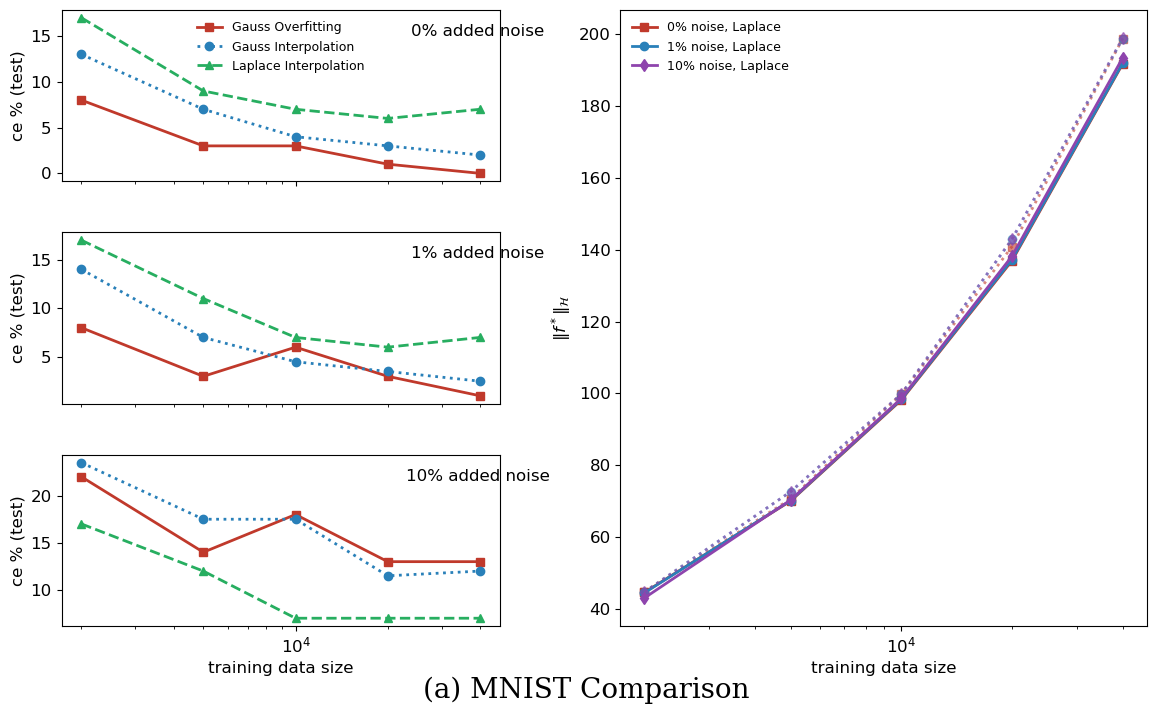

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plot_data = {}
for noise in plot_data_inv.keys():
    plot_data[noise] = {
        'sizes': plot_data_inv[noise]['sizes'],
        'inv_err': plot_data_inv[noise]['inv_err'],     # Gauss Interpolation
        'opt_err': plot_data_opt[noise]['opt_err'],     # Gauss Overfitting
        'lap_err': plot_data_lap[noise]['opt_err'],     # Laplace (Overfit)
        
        
        'inv_norm': [x.item() if torch.is_tensor(x) else x for x in plot_data_inv[noise]['inv_norm']],
        'opt_norm': [x.item() if torch.is_tensor(x) else x for x in plot_data_opt[noise]['opt_norm']],
        'lap_norm': [x.item() if torch.is_tensor(x) else x for x in plot_data_lap[noise]['opt_norm']]
    }


plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'lines.markersize': 6})
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.2], wspace=0.25, hspace=0.3)

ax_left_1 = plt.subplot(gs[0, 0])
ax_left_2 = plt.subplot(gs[1, 0])
ax_left_3 = plt.subplot(gs[2, 0])
ax_right  = plt.subplot(gs[:, 1])

axes_left = [ax_left_1, ax_left_2, ax_left_3]
colors = ['#C0392B', '#2980B9', '#8E44AD']
markers = ['s', 'o', 'd']

### Plot
sorted_noises = sorted(plot_data.keys())

for i, noise in enumerate(sorted_noises):
    ## Test error
    ax = axes_left[i]
    data = plot_data[noise]
    
    # Gaussian Overfitting (EigenPro)
    ax.plot(data['sizes'], data['opt_err'], color="#C0392B", marker='s', label='Gauss Overfitting')
    # Gaussian Interpolation (Dashed/Dotted)
    ax.plot(data['sizes'], data['inv_err'], color='#2980B9', marker='o', linestyle=':', label='Gauss Interpolation')
    # Laplacian Data
    ax.plot(data['sizes'], data['lap_err'], color="#27AE60", marker='^', linestyle='--', label='Laplace Interpolation')
    
    ax.set_xscale('log')
    ax.set_ylabel("ce % (test)")
    ax.text(0.95, 0.85, f"{int(noise*100)}% added noise", transform=ax.transAxes, ha='center')
    
    if i < 2: 
        ax.set_xticklabels([])
    else: 
        ax.set_xlabel("training data size")
        
    if i == 0: 
        ax.legend(frameon=False, fontsize=9)

    # RKHS Norm
    ax_right.plot(data['sizes'], data['inv_norm'], color=colors[i], marker=markers[i], linestyle=':', alpha=0.6)
    label_lap = f"{int(noise*100)}% noise, Laplace"
    ax_right.plot(data['sizes'], data['lap_norm'], color=colors[i], marker=markers[i], linestyle='-', label=label_lap)

ax_right.set_xscale('log')
ax_right.set_xlabel("training data size")
ax_right.set_ylabel(r"$\|f^*\|_{\mathcal{H}}$")
ax_right.legend(frameon=False, fontsize=9)

# Titre global type papier
fig.text(0.5, 0.02, '(a) MNIST Comparison', ha='center', fontsize=20, fontfamily='serif')

plt.show()